[View in Colaboratory](https://colab.research.google.com/github/zaidalyafeai/Notebooks/blob/master/Eager_Execution_Gradient_.ipynb)

# Enable Eager Execution 

In [1]:
import tensorflow as tf

tf.enable_eager_execution()

print('Is it enabled ? ', tf.executing_eagerly())

Is it enabled ?  True


As we know that TenosrFlow works with static graphs. So, first you have to create the graph then execute it later. This makes debugging a bit complicated. With Eager Execution you can now evalute operations directly without creating a session.

In [6]:
x = 2
m = tf.square(x)
print("x^2 = {}".format(m))

x^2 = 4


Cool, isn't it ? Now, let us look at a very important function called [tf.GradientTape ](https://https://www.tensorflow.org/api_docs/python/tf/GradientTape). This function allows you to record automatic differentiation operations. So If you evaluted a loss function $L$ included inside the scope of that function, you can evaluate the gradient with respect to the input. Seems complicated ? Let us see an example.  Suppose, we want to find the derivative of a simple function $f(x) = x^2$ at $x = 2$. Then do the following 

In [2]:
x = tf.Variable([[2.0]])
with tf.GradientTape() as tape:
  loss = x * x

grad = tape.gradient(loss, x)
print(grad)

tf.Tensor([[4.]], shape=(1, 1), dtype=float32)


As you can see the derivative is evaluted correctly as $f'(x = 2) = 2 \times 2 = 4$. This function is very important as it allows you to closely watch the gradient of the graph you are working on. Moreoever, you can calcuate the gradient of an arbitrary loss function and update the parameters accordingly. Let us take a look at a complicated example. 

# Evaluate the Gradient of a CNN
In this example we will create a loss function on a CNN model. Then we will evaluate the gradient and update the parameters of the model. We will train the model on mnist dataset.

## Load Data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


## Preprocess the Dataset

In [0]:
import numpy as np


x_train = tf.expand_dims(np.float32(x_train)/ 255., 3)
x_test  = tf.expand_dims(np.float32(x_test )/ 255., 3)

y_train = tf.one_hot(y_train, 10)
y_test  = tf.one_hot(y_test , 10)

## Look at the Data

Now since we use Eager Execution we can easily look at the data by calling `.numpy()` on the tenosr. This will return the numpy array 

Label : 5


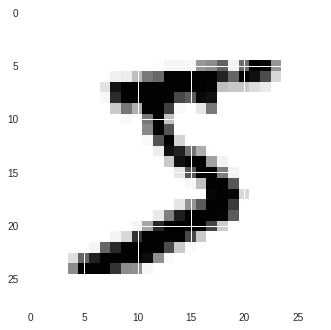

In [5]:
import matplotlib.pyplot as plt

img = x_train[0].numpy().squeeze()
lbl = np.argmax(y_train[0])
print('Label :', lbl)
plt.imshow(img)
plt.show()

## Get a Batch of the Data

In [0]:
import numpy as np
def get_batch(batch_size = 32):
  #get a random index to extract a batch 
  r = np.random.randint(0, 60000-batch_size)
  return x_train[r: r + batch_size], y_train[r: r + batch_size]

## Simple Model

In [7]:
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

def create_model():
  model = Sequential()
  model.add(Convolution2D(filters = 16, kernel_size = 3, padding = 'same', input_shape = [28, 28, 1], activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(BatchNormalization())
  model.add(Convolution2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(units = 100, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(units = 10 , activation = 'softmax'))
  return model

model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 32)          128       
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
__________

## Calculate the Loss and Gradient 

In [0]:
def loss(model, x, y):
  #use cross entropy
  prediction = model(x)
  return tf.losses.softmax_cross_entropy(y, logits=prediction)

def grad(model, x, y):
  #use tf.GradientTape() to record the gradient 
  with tf.GradientTape() as tape:
    loss_value = loss(model, x, y)
  return tape.gradient(loss_value, model.variables)

## Calcuate Accuracy of the Model 

In [0]:
def accuracy(model, x, y):
  #calcuate the model prediction eagerly 
  yhat = model(x)
  
  #compare the predictions to the truth
  yhat = tf.argmax(yhat, 1).numpy()
  y    = tf.argmax(y   , 1).numpy()
  return np.sum(y == yhat)/len(y)

## Training
Initialize the variables for training. Note that we need to know the length of an epoch in order to evaluate the metrics of the model. Also, we are using SGD to update the model paramteres 

In [0]:
#iterations and epochs variables 
i = 1
epoch = 0
epochs = 4 

#running loss and accuracy
running_loss = 0.
running_acc  = 0.

#calcuate the length of the epoch 
batch_size = 32 
epoch_length = x_train.numpy().shape[0] // batch_size

#optimizer to update the parmeters of the model 
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.05)

In [11]:
while epoch <= epochs:
  #get next batch
  x, y = get_batch(batch_size = batch_size)

  # Calculate derivatives of the input function with respect to its parameters.
  grads = grad(model, x, y)

  # Apply the gradient to the model
  optimizer.apply_gradients(zip(grads, model.variables),
                            global_step=tf.train.get_or_create_global_step())
  loss_value = loss(model, x, y)
  
  #calcuate running loss and accuracy 
  running_loss += loss_value
  running_acc  += accuracy(model, x, y)
  
  #report values at the end of the epoch 
  if i % epoch_length == 0:
    print("Epoch: {:d} Loss: {:.3f}, Acc: {:.3f}".format(epoch, running_loss/epoch_length, running_acc/epoch_length))
    
    #reset the running loss an accuracy 
    running_loss = 0 
    running_acc  = 0 
    
    epoch += 1
  i += 1

Epoch: 0 Loss: 1.706, Acc: 0.780
Epoch: 1 Loss: 1.498, Acc: 0.965
Epoch: 2 Loss: 1.485, Acc: 0.977
Epoch: 3 Loss: 1.480, Acc: 0.982
Epoch: 4 Loss: 1.477, Acc: 0.985


## Testing

In [12]:
print('Accuracy on the test set , ', accuracy(model, x_test, y_test))

Accuracy on the test set ,  0.9788


**Read more ** https://www.tensorflow.org/guide/eager